# Standard DSPOT and its modifications

Here, we apply DSPOT and its modificationd to the realTraffic dataset. We are looking to see under which conditions algorithm does perform well, what the main improvement areas and how to modify DSPOT making it more robust to non-stationary data

### Standard DSPOT

In [21]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ads_evt as spot
import json
from binned_dspot import BinnedDSPOT    # if you saved it as a module

from statsmodels.tsa.seasonal import STL
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf

# Load the data
df2 = pd.read_csv("../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df2.columns = ["timestamp", "value"]
data = df2.iloc[:, 1].values  # use second column for DSPOT

# Load the labels
with open("../data/raw_data/combined_windows.json") as f:
    all_windows = json.load(f)

dataset_key = "realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv" # set the key 
window_strs = all_windows.get(dataset_key, []) # get the list of window strings

# Convert to datetime tuples
anomaly_windows = [
    (datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f"),
     datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f"))
    for start, end in window_strs
]

We start with testing the simple DSPOT on half-cycle (144), full cycle depths (288) + two more arbitrary depths to see the robustness of the algorithm

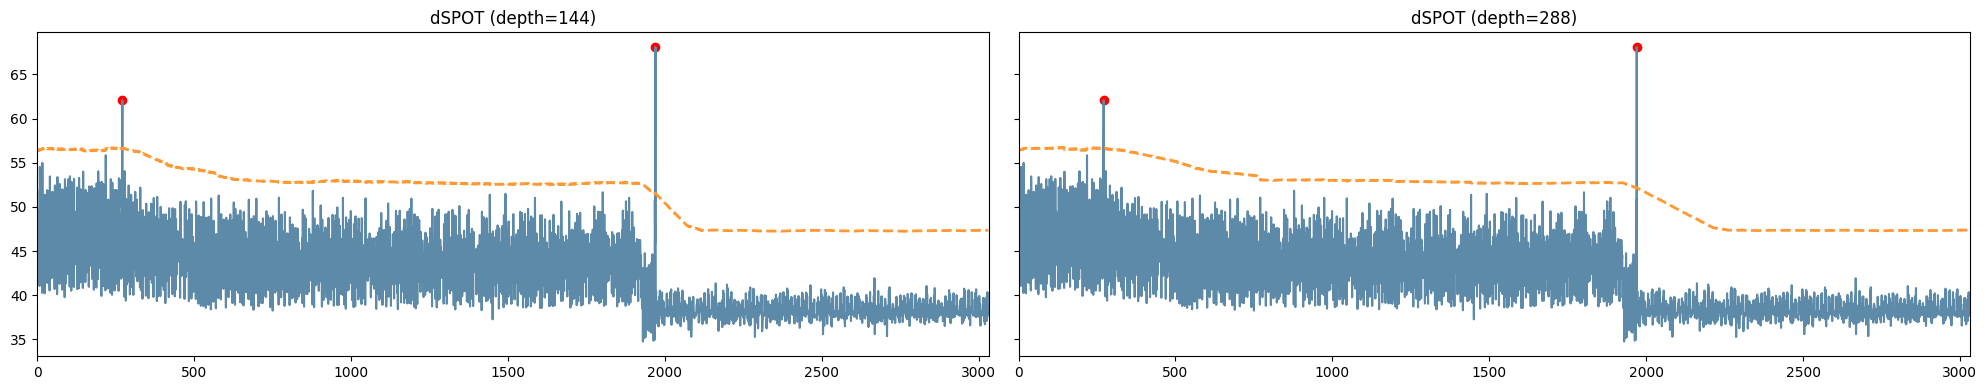

In [5]:
# Set parameters
init_data = 1000 # Initialization step
proba     = 1e-3  # User-defined false positive rate
depths    = [144, 288]  # Select a few more depths to see whather it influences the performance 

# Define plot grid
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharey=True)

# Loop over them
for ax, depth in zip(axes, depths):
    # make this axis the target
    plt.sca(ax)
    
    # init & fit DSPOT
    model = spot.dSPOT(q=proba, depth=depth)
    model.fit(init_data=init_data, data=data)
    model.initialize()
    results = model.run()
    
    # 3) plot into the current axis (plt.sca(ax) makes this happen)
    model.plot(results)
    
    # 4) then set the title on the Axes
    ax.set_title(f"dSPOT (depth={depth})")

# 5) tighten and show
plt.tight_layout()
plt.show()


Now, we use the provided real anomalies to evaluate the performance of the DSPOT on the realTraffic data. Since the real anomalies are defined as windows, we introduce the event-based anomaly detection. 

In [6]:
# Preload timestamps & anomaly windows
timestamps  = pd.to_datetime(df2.iloc[:, 0])

# Collect metrics per depth
metrics = {}   

for ax, depth in zip(axes, depths):
    # Run DSPOT
    model = spot.dSPOT(q=proba, depth=depth)
    model.fit(init_data=init_data, data=data)
    model.initialize()
    results = model.run()
    
    # Map alarms to timestamps
    alarm_offsets  = np.array(results["alarms"])
    detected_times = timestamps[init_data + alarm_offsets]

    # Compute metrics
    window_hits = [False] * len(anomaly_windows)
    FP = 0
    for ts in detected_times:
        matched = False
        for i, (start, end) in enumerate(anomaly_windows):
            if start <= ts <= end:
                window_hits[i] = True
                matched = True
                break
        if not matched:
            FP += 1

    TP = sum(window_hits)
    FN = len(anomaly_windows) - TP
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = (2 * precision * recall / (precision + recall)
                 if (precision + recall) > 0 else 0)

    # Store metrics
    metrics[depth] = {
        "TP": TP, "FP": FP, "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Print summary tables
for depth, m in metrics.items():
    print(f"\n=== depth = {depth} ===")
    print(f"  TP        : {m['TP']}")
    print(f"  FP        : {m['FP']}")
    print(f"  FN        : {m['FN']}")
    print(f"  Precision : {m['precision']:.3f}")
    print(f"  Recall    : {m['recall']:.3f}")
    print(f"  F1 Score  : {m['f1']:.3f}")


=== depth = 144 ===
  TP        : 2
  FP        : 0
  FN        : 0
  Precision : 1.000
  Recall    : 1.000
  F1 Score  : 1.000

=== depth = 288 ===
  TP        : 2
  FP        : 0
  FN        : 0
  Precision : 1.000
  Recall    : 1.000
  F1 Score  : 1.000


1. from sdl residuals for q=1e-5
TP: 3, FP: 6, FN: 1
Precision: 0.333, Recall: 0.750, F1: 0.462

1. from sdl residuals for q=1e-3
TP: 4, FP: 54, FN: 0
Precision: 0.069, Recall: 1.000, F1: 0.129

In [7]:
# Store delays by depth
all_delays = {} 

# Detection Delay 
for ax, depth in zip(axes, depths):
    # Run DSPOT
    model = spot.dSPOT(q=proba, depth=depth)
    model.fit(init_data=init_data, data=data)
    model.initialize()
    results = model.run()
    
    # Map alarms to timestamps
    timestamps     = pd.to_datetime(df2.iloc[:, 0])
    alarm_offsets  = np.array(results["alarms"])
    detected_times = timestamps[init_data + alarm_offsets]
    
    # Compute per-window delays in min
    delays_min = []
    for start, end in anomaly_windows:
        in_w = detected_times[(detected_times >= start) & (detected_times <= end)]
        if len(in_w):
            first_alarm = in_w.min()
            delta = (first_alarm - start).total_seconds() / 60.0
            delays_min.append(delta)
        else:
            delays_min.append(None)
    all_delays[depth] = delays_min

# Print summary tables 
for depth, delays in all_delays.items():
    valid = [d for d in delays if d is not None]
    mean_d = np.mean(valid)    if valid else np.nan
    med_d  = np.median(valid)  if valid else np.nan
    print(f"\nDepth = {depth}")
    for i, d in enumerate(delays, 1):
        txt = f"{d:.1f} min" if d is not None else "MISSED"
        print(f"  Window #{i}: {txt}")
    print(f"  → mean delay = {mean_d:.1f} min, median = {med_d:.1f} min")


Depth = 144
  Window #1: 500.0 min
  Window #2: 700.0 min
  → mean delay = 600.0 min, median = 600.0 min

Depth = 288
  Window #1: 500.0 min
  Window #2: 700.0 min
  → mean delay = 600.0 min, median = 600.0 min


### DSPOT Extensions for Stationary Residuals

While the moving‐average detrending produces perfect event-based scores, it does not fully remove non-stationary components from our series — as shown in the EVT-suitability analysis (realTraffic_EDA_and_EVT_fit.ipynb). That residual non-stationarity violates a core EVT assumption.

To address this, we will try two extensions:
1. Standardised residuals: compute the z-score of each point—i.e. subtract a rolling mean and divide by a rolling standard deviation over a suitably long window—to stabilize both the mean and variance. We’ll feed these standardized residuals into DSPOT so that any extreme deviations stand out against a unit-variance baseline.
2. STL decomposition: apply a robust STL fit (with the appropriate seasonal period) to remove trend and seasonal components entirely, leaving only the remainder series. Because STL explicitly separates seasonality and trend, the residuals should be closer to white noise while preserving the true extremes DSPOT needs to flag.
   
Wee will evaluate these approaches side-by-side to determine which yields the best compromise between strict stationarity and extreme-value preservation.

#### SPOT on STL Decomposed Residuals

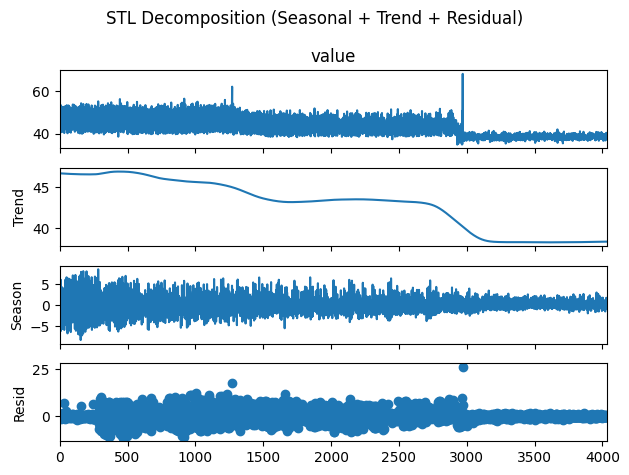

In [9]:
# Load the data
df2 = pd.read_csv("../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df2.columns = ["timestamp", "value"]

# Perform STL on the full-cycle data
stl = STL(df2['value'], period=288, robust = True)
res = stl.fit()

# Plot the results
res.plot()
plt.suptitle("STL Decomposition (Seasonal + Trend + Residual)")
plt.tight_layout()
plt.show()

<Figure size 800x300 with 0 Axes>

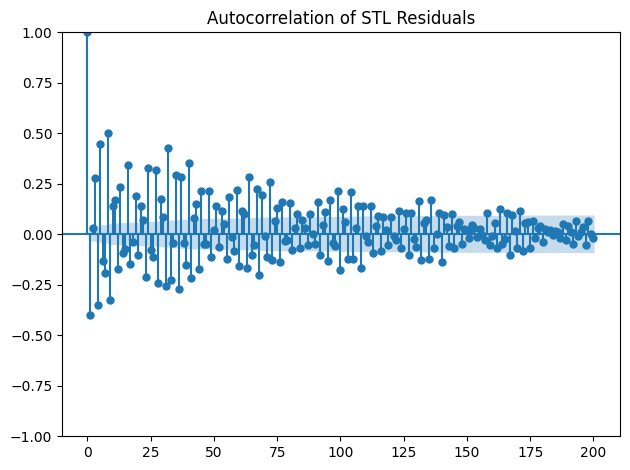

In [10]:
# Check ACF 
residuals = res.resid.dropna()

plt.figure(figsize=(8, 3))
plot_acf(residuals, lags=200)
plt.title("Autocorrelation of STL Residuals")
plt.tight_layout()
plt.show()

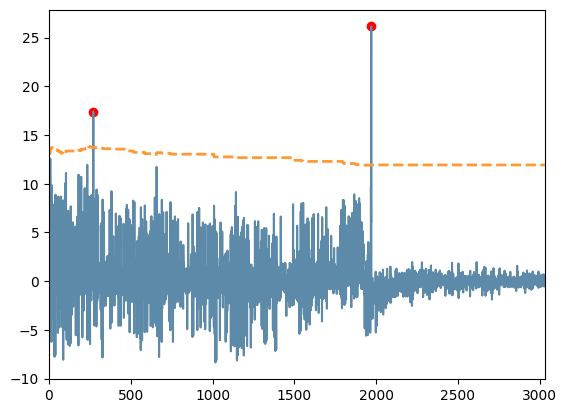

In [11]:
# Apply SPOT
model = spot.SPOT(q=1e-3)
model.fit(init_data=1000, data=residuals)
model.initialize()
results = model.run()

fig = model.plot(results)[0].figure
fig.savefig("dspot_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# 1) Build a clean DataFrame
df_clean = df2.copy()
df_clean["resid"] = res.resid

# 2) Drop rows where the residual is NaN
df_clean = df_clean.dropna(subset=["resid"]).reset_index(drop=True)
# Now df_clean has a 0…M–1 integer index matching df_clean["resid"].values

# 3) Run SPOT on df_clean["resid"].values
model = spot.SPOT(q=1e-3)
model.fit(init_data=init_data, data=df_clean["resid"].values)
model.initialize()
results = model.run()

# 4) Map offsets back into df_clean
alarm_offsets = np.array(results["alarms"])
detected_times = df_clean.loc[init_data + alarm_offsets, "timestamp"]

# 5) Compute metrics exactly as before
window_hits = [False] * len(anomaly_windows)
FP = 0
for ts in detected_times:
    matched = False
    for i, (start, end) in enumerate(anomaly_windows):
        if start <= ts <= end:
            window_hits[i] = True
            matched = True
            break
    if not matched:
        FP += 1

TP = sum(window_hits)
FN = len(anomaly_windows) - TP
precision = TP / (TP + FP) if (TP + FP) else 0
recall    = TP / (TP + FN) if (TP + FN) else 0
f1        = (2 * precision * recall / (precision + recall)
             if (precision + recall) else 0)

# 6) Print
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


TP: 2, FP: 0, FN: 0
Precision: 1.000, Recall: 1.000, F1: 1.000


SPOT and std residuals

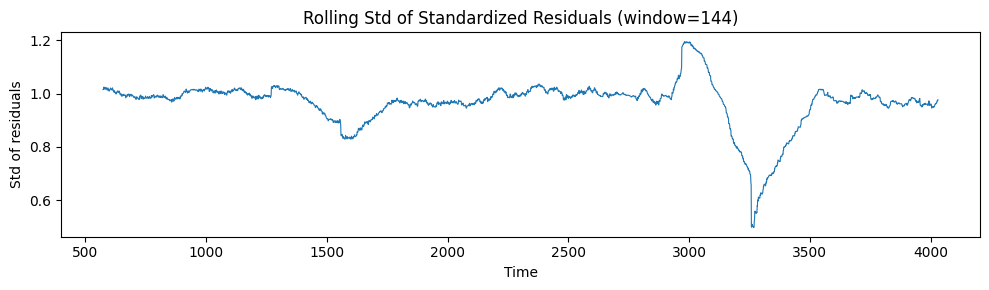

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df_post = pd.read_csv("../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df_post.columns = ["timestamp", "value"]
#df = df.set_index("timestamp")

# Parameters
window = 288 # based on acf plot

# Rolling mean & std
df_post["mu"] = df_post["value"].rolling(window).mean()
df_post["sigma"] = df_post["value"].rolling(window).std()

# Standardized residual
df_post["resid"] = (df_post["value"] - df_post["mu"]) / (df_post["sigma"] + 1e-6)

# Drop NaNs
df_post = df_post.dropna(subset=["resid"])

# Rolling std of residuals
df_post["resid_std"] = df_post["resid"].rolling(window).std()

plt.figure(figsize=(10,3))
plt.plot(df_post.index, df_post["resid_std"], lw=0.8)
plt.title("Rolling Std of Standardized Residuals (window=144)")
plt.xlabel("Time")
plt.ylabel("Std of residuals")
plt.tight_layout()
plt.show()


<Figure size 800x300 with 0 Axes>

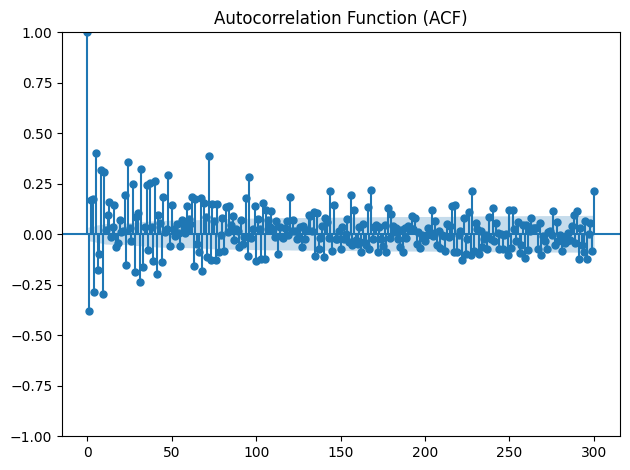

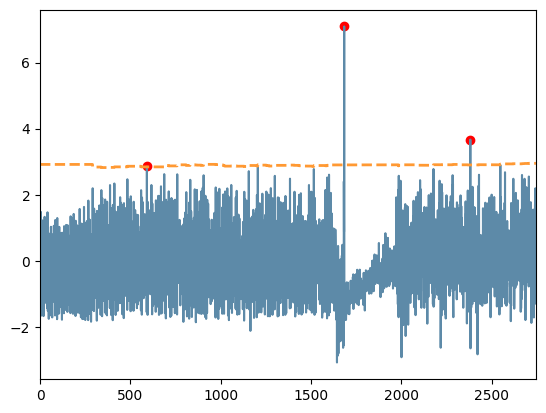

In [81]:
import ads_evt as spot
from statsmodels.graphics.tsaplots import plot_acf

resids = df_post["resid"].values  # already zero-mean and unit-variance

plt.figure(figsize=(8, 3))
plot_acf(resids, lags=300)
plt.title("Autocorrelation Function (ACF)")
plt.tight_layout()
plt.show()

# 2) Drop rows where the residual is NaN
resids = df_post.dropna(subset=["resid"]).reset_index(drop=True)
# Now df_clean has a 0…M–1 integer index matching df_clean["resid"].values

# 3) Run SPOT on df_clean["resid"].values
model = spot.SPOT(q=1e-3)
model.fit(init_data=init_data, data=resids["resid"].values)
model.initialize()
results = model.run()

fig = model.plot(results)[0].figure
fig.savefig("dspot_plot.png", dpi=300, bbox_inches='tight')

plt.show()




STL + variance normalization on SPOT

In [70]:

# --- 1) STL detrending ---
df2 = pd.read_csv("../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])
df2.columns = ["timestamp", "value"]

stl = STL(df2["value"], period=288, robust=True)
res = stl.fit()
residuals = res.resid  # still aligned to df2.index

# --- 2) Rolling‐std normalization ---
# choose a window that spans at least one season, e.g. 288
roll_win = 288
sigma = residuals.rolling(window=roll_win, center=False).std()

# Avoid division by zero
sigma[sigma == 0] = np.nan  

z_resid = residuals / sigma

# Drop the first roll_win points (NaNs)
df_clean = pd.DataFrame({
    "timestamp": df2["timestamp"],
    "z": z_resid
}).dropna().reset_index(drop=True)

# --- 3) Run SPOT on the z-scores ---
init_data = 1000
q         = 1e-3

model = spot.SPOT(q=q)
model.fit(init_data=init_data, data=df_clean["z"].values)
model.initialize()
results = model.run()

# Map alarms back to timestamps
alarm_offsets  = np.array(results["alarms"])
detected_times = df_clean.loc[init_data + alarm_offsets, "timestamp"]

# --- 4) Compute event-based metrics ---
window_hits = [False] * len(anomaly_windows)
FP = 0
for ts in detected_times:
    matched = False
    for i, (start, end) in enumerate(anomaly_windows):
        if start <= ts <= end:
            window_hits[i] = True
            matched = True
            break
    if not matched:
        FP += 1

TP = sum(window_hits)
FN = len(anomaly_windows) - TP
precision = TP / (TP + FP) if (TP + FP) else 0
recall    = TP / (TP + FN) if (TP + FN) else 0
f1        = (2 * precision * recall / (precision + recall)
             if (precision + recall) else 0)

print(f"STL + rolling‐std + SPOT (q={q}):")
print(f"  TP        : {TP}")
print(f"  FP        : {FP}")
print(f"  FN        : {FN}")
print(f"  Precision : {precision:.3f}")
print(f"  Recall    : {recall:.3f}")
print(f"  F1 Score  : {f1:.3f}")


STL + rolling‐std + SPOT (q=0.001):
  TP        : 1
  FP        : 0
  FN        : 1
  Precision : 1.000
  Recall    : 0.500
  F1 Score  : 0.667


what next? 

In [ ]:
Binned DSPOT

Detected 0 anomalies out of 1532 samples


,index,timestamp,value


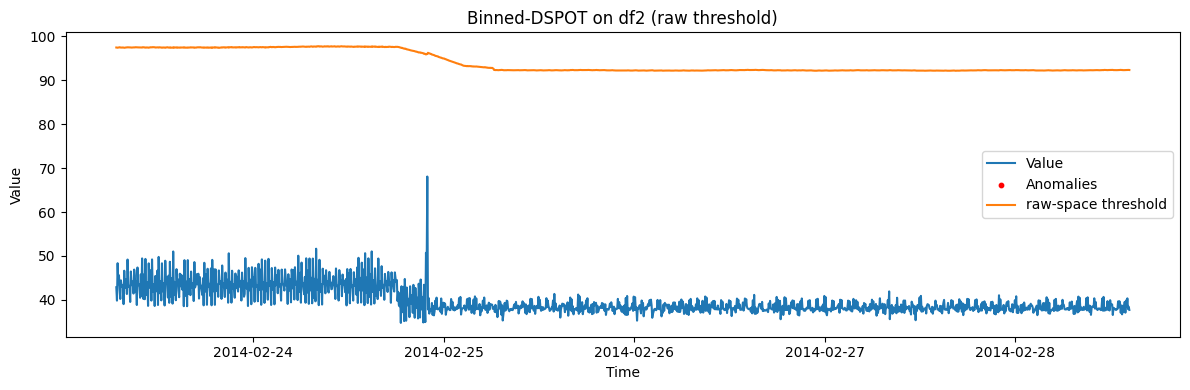

In [78]:
# works for traffic
# %%  
# 1) Definition of the fixed BinnedDSPOT  
import numpy as np  
import matplotlib.pyplot as plt  

class BinnedDSPOT:  
    def __init__(  
        self,  
        q=1e-4,  
        init_data=None,  
        num_bins=50,  
        t_quantile=0.98,  
        window_size=200,  
        min_bin_count=5,  
        xmin_floor=1e-3,  
        force_min_alpha=0.5,  
        use_equipopulated=False  
    ):  
        self.q = q  
        self.num_bins = num_bins  
        self.window_size = window_size  
        self.min_bin_count = min_bin_count  
        self.xmin_floor = xmin_floor  
        self.force_min_alpha = force_min_alpha  
        self.use_equipopulated = use_equipopulated  

        self.t = None  
        self.bin_edges = None  
        self.counts = None  
        self.N_t = 0  
        self.n = 0  
        self.alpha = None  
        self.xmin = None  
        self.z_q = None  

        self.window = []  

        if init_data is not None:  
            self.fit_initial(init_data, t_quantile)  

    def fit_initial(self, data, t_quantile=0.98):  
        self.n = len(data)  
        self.t = np.quantile(data, t_quantile)  
        excesses = data[data > self.t] - self.t  
        self.N_t = len(excesses)  
        if self.N_t < 1:  
            raise ValueError("Not enough peaks above threshold for initial fit.")  

        if self.use_equipopulated:  
            sorted_ex = np.sort(excesses)  
            qs = np.linspace(0, 1, self.num_bins + 1)  
            self.bin_edges = np.unique(np.quantile(sorted_ex, qs))  
        else:  
            raw_xmin = excesses.min()  
            raw_xmax = excesses.max()  
            self.bin_edges = np.logspace(  
                np.log10(raw_xmin), np.log10(raw_xmax), self.num_bins + 1  
            )  

        self.counts, _ = np.histogram(excesses, bins=self.bin_edges)  
        self._estimate_tail()  
        self._update_threshold()  

    def _estimate_tail(self):  
        counts = self.counts + 1  
        mids = np.sqrt(self.bin_edges[:-1] * self.bin_edges[1:])  
        mask = counts >= self.min_bin_count  
        if not np.any(mask):  
            raise RuntimeError("No bins have enough counts for tail estimation.")  

        x = np.log(mids[mask])  
        y = np.log(counts[mask])  
        A = np.vstack([x, np.ones_like(x)]).T  
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]  
        raw_alpha = -slope  

        self.alpha = max(raw_alpha, 1)  
        raw_xmin = mids[mask][0]  
        self.xmin = max(raw_xmin, self.xmin_floor)  

    def _update_threshold(self):  
        factor = (self.N_t / (self.q * self.n)) ** (1 / self.alpha)  
        self.z_q = self.t + self.xmin * factor - self.xmin  


    def update(self, x_new):  
        self.window.append(x_new)  
        if len(self.window) > self.window_size:  
            self.window.pop(0)  
        M = np.mean(self.window)  

        x_resid = x_new - M  
        self.n += 1  

        #if x_resid > self.z_q:  # compare to the residuals 
         #   return True  
        if x_new > (M + self.z_q): # compare to the raw value
            return True


        if x_resid > self.t:  
            y = x_resid - self.t  
            idx = np.searchsorted(self.bin_edges, y, side='right') - 1  
            if 0 <= idx < len(self.counts):  
                self.counts[idx] += 1  
                self.N_t += 1  
                self._estimate_tail()  
                self._update_threshold()  

        return False  


# 3) LOAD & PREPARE DATA  
df2 = pd.read_csv("../data/raw_data/ec2_cpu_utilization_5f5533.csv", parse_dates=[0])  
df2.columns = ["timestamp","value"]  
# use STL residuals if you like, else raw df2["value"]  
# from statsmodels.tsa.seasonal import STL  
# stl = STL(df2.value, period=288, robust=True).fit()  
# data = stl.resid.dropna().values  

timestamps = df2.timestamp.values  
data       = df2.value.values  

# choose a window that adapts in ~6–12 hours instead of 2 days
window_size = 100   # 200 × 5 minutes = ~16 hours
init_size = 2500
detector = BinnedDSPOT(
    q=1e-2,
    init_data       = data[:2500],
    num_bins        = 10,
    t_quantile      = 0.95,
    window_size     = window_size,
    min_bin_count   = 1,
    xmin_floor      = 0.5,
    force_min_alpha = 1.0,
    use_equipopulated = True
)
# init_size = 2000, window_size = 500
# assume init_size and window_size are defined
detector.window = list(data[init_size-window_size : init_size])

detector.n      = init_size

M_history = []
z_history = []
anomaly_idxs = []
anomaly_vals = []

for i, x in enumerate(data[init_size:], start=init_size):
    # 1) compute local mean over the last `window_size` points
    M = np.mean(detector.window)
    M_history.append(M)

    
    # original update only returns True/False, but we use the new logic:
    detector.window.append(x)
    if len(detector.window) > detector.window_size:
        detector.window.pop(0)
    x_resid = x - M
    detector.n += 1

    # flag by raw value
    if x > M + detector.z_q:
        anomaly_idxs.append(i)
        anomaly_vals.append(x)
    elif x_resid > detector.t:
        # peak update as before
        y = x_resid - detector.t
        idx = np.searchsorted(detector.bin_edges, y, side='right') - 1
        if 0 <= idx < len(detector.counts):
            detector.counts[idx] += 1
            detector.N_t += 1
            detector._estimate_tail()
            detector._update_threshold()

    z_history.append(detector.z_q)

print(f"Detected {len(anomaly_vals)} anomalies out of {len(data)-init_size} samples")  
# %%  
# 5) Build results DataFrame and show top anomalies  
import pandas as pd  
results = pd.DataFrame({  
    'index':     anomaly_idxs,  
    'timestamp': timestamps[anomaly_idxs],  
    'value':     anomaly_vals  
})  
display(results.head())  


# 6) Plot stream, anomalies, and **raw** threshold  
plt.figure(figsize=(12,4))  
plt.plot(timestamps[init_size:], data[init_size:], label='Value')  
plt.scatter(timestamps[anomaly_idxs], anomaly_vals, s=10, color='red', label='Anomalies')  

# compute raw thresholds = M_history + z_history
raw_thresh = np.array(M_history) + np.array(z_history)
plt.plot(timestamps[init_size:], raw_thresh, label='raw-space threshold')  

plt.xlabel('Time')  
plt.ylabel('Value')  
plt.title('Binned-DSPOT on df2 (raw threshold)')  
plt.legend()  
plt.tight_layout()  
plt.show()



In [75]:
from itertools import product
import pandas as pd

# 0) Ensure your windows and timestamps are datetime once, up-front:
anomaly_windows = [
    (pd.to_datetime(s), pd.to_datetime(e))
    for s, e in anomaly_windows
]
# 1) Hyper-parameter grid (include the 5 000 you used!)
init_sizes    = [100, 200, 400, 600, 1000, 2000, 5000]
num_bins_list = [2, 10, 5, 15, 50, 100]
min_counts    = [1, 2, 5]
alphas        = [0.3, 0.1, 0.5, 1.0]    # force_min_alpha

results = []
for init_size, nb, mc, fa in product(init_sizes, num_bins_list, min_counts, alphas):
    if init_size >= len(values):
        continue

    # try to initialize with the *same* q you used
    try:
        det = BinnedDSPOT(
            q=1e-4,                     # match your working run
            init_data=values[:init_size],
            num_bins=nb,
            t_quantile=0.98,
            window_size=200,
            min_bin_count=mc,
            xmin_floor=1e-3,
            force_min_alpha=fa,
            use_equipopulated=True
        )
    except Exception:
        continue

    # 2) stream & collect detections
    detected = []
    for i, x in enumerate(values[init_size:], start=init_size):
        if det.update(x):
            detected.append(timestamps[i])

    # 3) score against your anomaly_windows
    TP = FP = 0
    hits = [False]*len(anomaly_windows)
    for ts in detected:
        match = False
        for j,(start,end) in enumerate(anomaly_windows):
            if start <= ts <= end:
                hits[j] = True
                match = True
                break
        if not match:
            FP += 1
    TP = sum(hits)
    FN = len(anomaly_windows) - TP
    prec = TP/(TP+FP) if TP+FP else 0
    rec  = TP/(TP+FN) if TP+FN else 0
    f1   = (2*prec*rec/(prec+rec)) if prec+rec else 0

    results.append({
        'init_size': init_size,
        'num_bins': nb,
        'min_count': mc,
        'min_alpha': fa,
        'TP': TP, 'FP': FP, 'FN': FN,
        'precision': prec, 'recall': rec, 'f1': f1
    })

df_scores = pd.DataFrame(results).sort_values('f1', ascending=False)
display(df_scores.head())


,init_size,num_bins,min_count,min_alpha,TP,FP,FN,precision,recall,f1
0,100,2,1,0.3,0,0,2,0,0.0,0
1,100,2,1,0.1,0,0,2,0,0.0,0
218,1000,10,2,0.5,0,0,2,0,0.0,0
217,1000,10,2,0.1,0,0,2,0,0.0,0
216,1000,10,2,0.3,0,0,2,0,0.0,0
